# Deep Ensemble + Uncertainty + SHAP Analysis

This notebook demonstrates:
> **Why deep ensembles?** We work with a **small dataset**, where a single MLP can be **highly sensitive** to (i) **random weight initialization** and (ii) the **training/validation split**.  
> Training an **ensemble of independently initialized models** (often with bootstrap resampling) helps stabilize predictions and provides an estimate of **epistemic uncertainty**.

1. **Dataset Generation** - Creating synthetic nonlinear beam deflection data  
2. **Surrogate Modeling** - Training a deep ensemble with uncertainty quantification  
3. **Sensitivity Analysis** - Using SHAP to understand feature importance with uncertainty quantification from the model

---


## Setup & Imports

In [1]:
import random
from dataclasses import dataclass
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import shap

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"SHAP version: {shap.__version__}")

PyTorch version: 2.9.1+cu128
CUDA available: True
SHAP version: 0.49.1


/home/sacha.durain/forecasting_temporelle/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration

In [ ]:
# Global configuration
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Data configuration
FEATURE_NAMES = ["P_load_N", "E_Pa", "h_m"]
TARGET_NAME = "delta_m"

# Dataset generation
N_SAMPLES = 200

# Train/test splits
TEST_SIZE = 0.2
VAL_SIZE = 0.2

# Ensemble configuration
M_ENSEMBLE = 10
EPOCHS = 2000
BATCH_SIZE = 32
LR = 2e-3
WEIGHT_DECAY = 2e-4
PATIENCE = 200

# SHAP configuration
MAX_EXPLAIN = 120
SHAP_BACKGROUND = 50

print(f"Device: {DEVICE}")
print(f"Random seed: {SEED}")

Device: cuda
Random seed: 42


In [3]:
def set_seed(seed: int):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

---

# PART 1: Dataset Generation

We generate synthetic data for a **nonlinear beam deflection problem**.

**Physics Model:**
- A simply supported beam under central load P
- Nonlinear stiffness: $k_3\delta^3 + k_1\delta - P = 0$

**Input Features:**
- `P`: Load (N)
- `E`: Young's modulus (Pa)
- `h`: Beam height (m)

**Output:**
- `delta`: Beam deflection (m)

Generated 200 samples
X shape: (200, 3), y shape: (200, 1)
Noise level: 0% (deterministic)


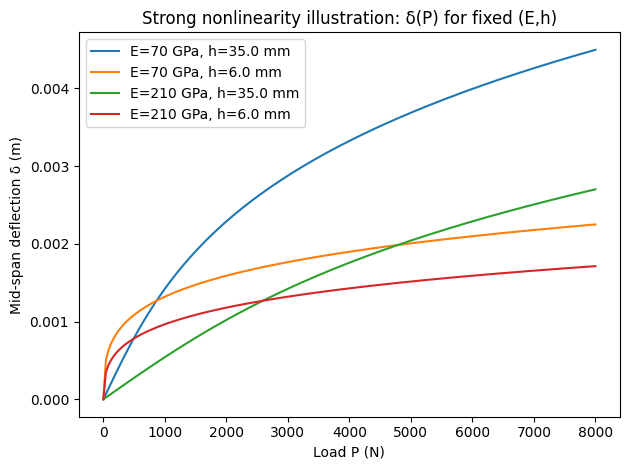

In [ ]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


@dataclass
class BeamParams:
    """Parameters for a strongly nonlinear beam model."""
    L: float = 1.0
    b: float = 0.05

    # Strong nonlinearity controls
    k3_factor: float = 0.50
    k5_factor: float = 5.0

    # Solver params
    tol: float = 1e-10
    max_iter: int = 200
    max_delta: float = 0.5


def solve_beam_deflection(P, E, h, params: BeamParams) -> float:
    """
    Solve: k5*δ^5 + k3*δ^3 + k1*δ - P = 0  for δ >= 0
    Strongly nonlinear (hardening) model. Robust bisection bracketing.
    """
    L, b = params.L, params.b
    A = b * h
    I = b * h**3 / 12.0

    # Linear stiffness proxy (simply supported beam, central load)
    k1 = 48.0 * E * I / (L**3)  # [N/m]

    # Thickness-sensitive nonlinearities (strong when h is small)
    base = (E * A) / (L**3)     # [N/m^2]
    k3 = params.k3_factor * base / (h**2)  # [N/m^3]
    k5 = params.k5_factor * base / (h**4)  # [N/m^5]

    def f(d):
        return (k5 * d**5) + (k3 * d**3) + (k1 * d) - P

    # Bracket
    lo = 0.0
    hi = 1e-9
    fhi = f(hi)
    while fhi <= 0.0 and hi < params.max_delta:
        hi *= 2.0
        fhi = f(hi)

    if fhi <= 0.0:
        return float(params.max_delta)

    # Bisection
    for _ in range(params.max_iter):
        mid = 0.5 * (lo + hi)
        fmid = f(mid)
        if abs(fmid) < params.tol or (hi - lo) < params.tol:
            return float(mid)
        if fmid > 0:
            hi = mid
        else:
            lo = mid

    return float(0.5 * (lo + hi))


def generate_dataset(n: int, seed: int, params: BeamParams):
    """
    Small dataset (few simulations), WITHOUT noise.
    Inputs: P (N), E (Pa), h (m). Output: delta (m)
    """
    rng = np.random.default_rng(seed)

    P = rng.uniform(50.0, 8000.0, size=n)
    E = rng.uniform(70e9, 210e9, size=n)
    h = rng.uniform(0.003, 0.04, size=n)

    delta = np.zeros(n, dtype=float)
    for i in range(n):
        delta[i] = solve_beam_deflection(P[i], E[i], h[i], params)

    y = delta.reshape(-1, 1)
    X = np.stack([P, E, h], axis=1)
    return X, y


def plot_nonlinearity_cases(params: BeamParams, n_cases: int = 4, n_points: int = 150):
    """
    Plot δ(P) for a few fixed (E,h) cases to illustrate strong nonlinearity.
    """
    # Pick representative cases (you can change these to match your domain)
    cases = [
        {"E": 70e9,  "h": 0.035},
        {"E": 70e9,  "h": 0.006},
        {"E": 210e9, "h": 0.035},
        {"E": 210e9, "h": 0.006},
    ][:n_cases]

    P_grid = np.linspace(0.0, 8000.0, n_points)

    plt.figure()
    for c in cases:
        E, h = c["E"], c["h"]
        deltas = np.array([solve_beam_deflection(P, E, h, params) for P in P_grid])
        label = f"E={E/1e9:.0f} GPa, h={h*1e3:.1f} mm"
        plt.plot(P_grid, deltas, label=label)

    plt.xlabel("Load P (N)")
    plt.ylabel("Mid-span deflection δ (m)")
    plt.title("Strong nonlinearity illustration: δ(P) for fixed (E,h)")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ----------------------------
# Example usage
# ----------------------------

# Hardcoded example config (adapt to your variables)
N_SAMPLES = 200
SEED = 42
FEATURE_NAMES = ["P_load_N", "E_Pa", "h_m"]
TARGET_NAME = "delta_m"

params = BeamParams(
    L=1.0,
    b=0.05,
    k3_factor=0.50,
    k5_factor=5.0,
)

X, y = generate_dataset(N_SAMPLES, SEED, params)

df = pd.DataFrame(X, columns=FEATURE_NAMES)
df[TARGET_NAME] = y

# Plot a few deterministic curves to show nonlinearity
plot_nonlinearity_cases(params, n_cases=4, n_points=200)


### Split & Scale Data

In [6]:
# Split data
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)
X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=VAL_SIZE, random_state=SEED)

print(f"Train: {len(X_tr)}, Val: {len(X_va)}, Test: {len(X_te)}")

# Scale data
x_scaler = StandardScaler().fit(X_tr)
y_scaler = StandardScaler().fit(y_tr)

X_tr_s = x_scaler.transform(X_tr)
X_va_s = x_scaler.transform(X_va)
X_te_s = x_scaler.transform(X_te)

y_tr_s = y_scaler.transform(y_tr)
y_va_s = y_scaler.transform(y_va)
y_te_s = y_scaler.transform(y_te)

print("✓ Data split and scaled")

Train: 128, Val: 32, Test: 40
✓ Data split and scaled


---

# PART 2: Surrogate Modeling with Deep Ensemble

Train an **ensemble of neural networks** to predict beam deflection.

**Key features:**
- Bootstrap sampling for diversity
- Early stopping to prevent overfitting
- **Epistemic uncertainty** quantification via ensemble variance

### Model Architecture

In [7]:
class MLPRegressor(nn.Module):
    """Multi-layer perceptron for regression."""
    def __init__(self, in_dim=3, hidden=(64, 64), dropout=0.0):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Test model creation
test_model = MLPRegressor(in_dim=3, hidden=(64, 64))
print(f"Model architecture:\n{test_model}")
print(f"\nTotal parameters: {sum(p.numel() for p in test_model.parameters())}")

Model architecture:
MLPRegressor(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

Total parameters: 4481


### Training Functions

In [8]:
def train_one_model(
    X_train_s, y_train_s,
    X_val_s, y_val_s,
    seed: int,
    epochs: int,
    batch_size: int,
    lr: float,
    weight_decay: float,
    patience: int,
    device: str,
):
    """
    Train a single MLP model with early stopping.
    
    Returns:
        model: Trained PyTorch model
        best_val: Best validation loss
    """
    set_seed(seed)

    model = MLPRegressor(in_dim=X_train_s.shape[1], hidden=(64, 64), dropout=0.0).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    train_ds = TensorDataset(
        torch.tensor(X_train_s, dtype=torch.float32),
        torch.tensor(y_train_s, dtype=torch.float32),
    )
    loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)

    val_x = torch.tensor(X_val_s, dtype=torch.float32).to(device)
    val_y = torch.tensor(y_val_s, dtype=torch.float32).to(device)

    best_val = float("inf")
    best_state = None
    no_improve = 0

    for _ in range(epochs):
        model.train()
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            vpred = model(val_x)
            vloss = loss_fn(vpred, val_y).item()

        if vloss < best_val - 1e-7:
            best_val = vloss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val


@torch.no_grad()
def ensemble_predict_scaled(models, X_s: np.ndarray, device: str):
    """
    Predicts in normalized space.
    
    Returns:
      mean_s: (n,1) - mean prediction
      var_s : (n,1) - variance inter-models (epistemic uncertainty proxy)
      all_s : (M,n,1) - all individual predictions
    """
    x = torch.tensor(X_s, dtype=torch.float32).to(device)
    preds = []
    for m in models:
        m.eval()
        preds.append(m(x).detach().cpu().numpy())
    all_preds = np.stack(preds, axis=0)
    mean = np.mean(all_preds, axis=0)
    var = np.var(all_preds, axis=0, ddof=1)
    return mean, var, all_preds

print("✓ Training functions defined")

✓ Training functions defined


### Train Ensemble

In [9]:
# Train ensemble with bootstrap
models = []
val_losses = []
n_train = len(X_tr_s)
rng = np.random.default_rng(SEED)

print(f"Training {M_ENSEMBLE} models with bootstrap...")
print(f"Device: {DEVICE}\n")

t0 = time.time()
for m in range(M_ENSEMBLE):
    # Bootstrap sampling
    idx = rng.integers(low=0, high=n_train, size=n_train)
    Xb = X_tr_s[idx]
    yb = y_tr_s[idx]

    seed_m = SEED + 1000 + m * 17
    model, vloss = train_one_model(
        Xb, yb, X_va_s, y_va_s,
        seed=seed_m,
        epochs=EPOCHS,
        batch_size=min(BATCH_SIZE, max(8, n_train)),
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        patience=PATIENCE,
        device=DEVICE,
    )
    models.append(model)
    val_losses.append(vloss)
    print(f"  Model {m+1}/{M_ENSEMBLE}: val_loss = {vloss:.6f}")

train_time = time.time() - t0
print(f"\n✓ Ensemble training complete in {train_time:.2f}s")
print(f"Average validation loss: {np.mean(val_losses):.6f} ± {np.std(val_losses):.6f}")

Training 10 models with bootstrap...
Device: cuda

  Model 1/10: val_loss = 0.004005
  Model 2/10: val_loss = 0.023914
  Model 3/10: val_loss = 0.005771
  Model 4/10: val_loss = 0.020088
  Model 5/10: val_loss = 0.005720
  Model 6/10: val_loss = 0.005534
  Model 7/10: val_loss = 0.013612
  Model 8/10: val_loss = 0.005600
  Model 9/10: val_loss = 0.004337
  Model 10/10: val_loss = 0.010610

✓ Ensemble training complete in 39.74s
Average validation loss: 0.009919 ± 0.006725


### Predict & Evaluate

In [18]:
# Predict on test set
mean_s, var_s, all_s = ensemble_predict_scaled(models, X_te_s, device=DEVICE)
y_pred = y_scaler.inverse_transform(mean_s)

# Epistemic variance in original units: var_orig = var_scaled * y_scale^2
y_scale = float(y_scaler.scale_[0])
y_var_epistemic = var_s * (y_scale ** 2)

# Calculate metrics
pred_mean = float(np.mean(y_pred))
pred_var = float(np.var(y_pred))
epistemic_mean_var = float(np.mean(y_var_epistemic))
epistemic_var_var = float(np.var(y_var_epistemic))

print("\n=== METRICS ===")
print(f"Prediction mean:                {pred_mean:.6e}")
print(f"Prediction variance:            {pred_var:.6e}")
print(f"Epistemic uncertainty mean:     {epistemic_mean_var:.6e}")
print(f"Epistemic uncertainty variance: {epistemic_var_var:.6e}")
print(f"Training time:                  {train_time:.2f}s")


=== METRICS ===
Prediction mean:                2.205381e-03
Prediction variance:            5.853324e-07
Epistemic uncertainty mean:     1.332731e-09
Epistemic uncertainty variance: 1.659525e-18
Training time:                  39.74s


---

# PART 3: Sensitivity Analysis with SHAP

Use **SHAP (SHapley Additive exPlanations)** to understand:
- Which features are most important?
- How do features influence predictions?
- Model interpretability with uncertainty quantification from the model

### SHAP Wrapper

In [21]:
class EnsembleWrapper:
    """
    Callable for SHAP:
      input: X in original units
      output: y_pred_mean in original units (shape (n,))
    """
    def __init__(self, models, x_scaler: StandardScaler, y_scaler: StandardScaler, device: str):
        self.models = models
        self.x_scaler = x_scaler
        self.y_scaler = y_scaler
        self.device = device

    def __call__(self, X: np.ndarray) -> np.ndarray:
        X = np.asarray(X, dtype=float)
        X_s = self.x_scaler.transform(X)
        mean_s, _, _ = ensemble_predict_scaled(self.models, X_s, self.device)
        mean = self.y_scaler.inverse_transform(mean_s).ravel()
        return mean

# Create wrapper
wrapper = EnsembleWrapper(models, x_scaler, y_scaler, device=DEVICE)
print("✓ Ensemble wrapper created for SHAP")

✓ Ensemble wrapper created for SHAP


### Compute SHAP Values

In [22]:
# Sample background data
bg = shap.sample(X_tr, min(SHAP_BACKGROUND, len(X_tr)), random_state=0)
print(f"Background samples: {len(bg)}")

# Create explainer
explainer = shap.KernelExplainer(wrapper, bg)

# Select samples to explain
X_explain = X_te if len(X_te) <= MAX_EXPLAIN else shap.sample(X_te, MAX_EXPLAIN, random_state=1)
print(f"Explaining {len(X_explain)} test samples...")

# Compute SHAP values (this may take a few minutes)
shap_values = explainer.shap_values(X_explain, nsamples="auto")
if isinstance(shap_values, list):
    shap_values = shap_values[0]

print(f"✓ SHAP values computed: {shap_values.shape}")

Background samples: 50
Explaining 40 test samples...


100%|██████████| 40/40 [00:00<00:00, 196.62it/s]

✓ SHAP values computed: (40, 3)


### SHAP Feature Importance

Feature Importance Statistics:
P_load_N       : mean=0.000457, std=0.000350, var=1.225089e-07
E_Pa           : mean=0.000222, std=0.000127, var=1.625515e-08
h_m            : mean=0.000273, std=0.000137, var=1.867033e-08


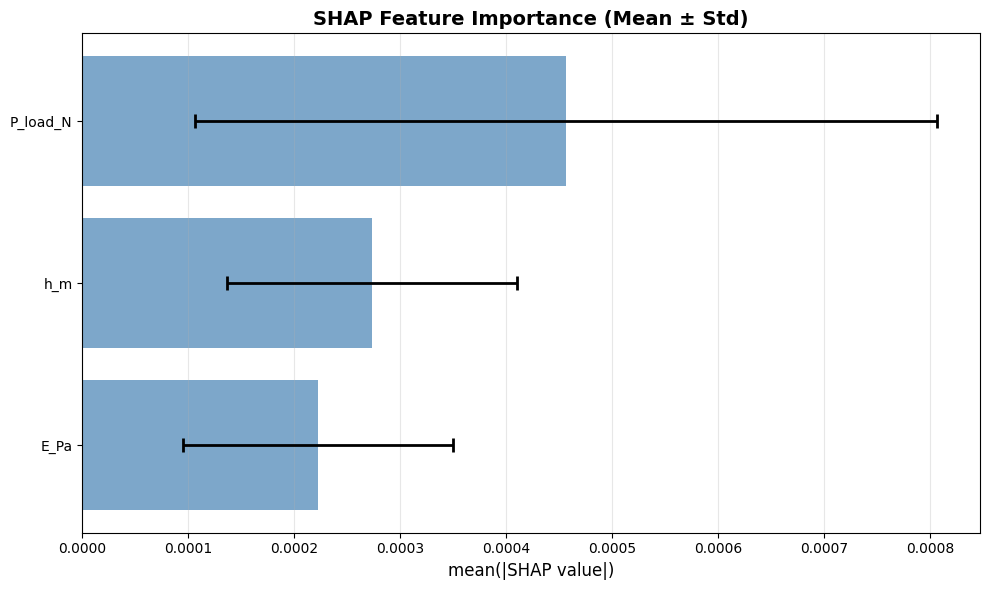

In [24]:
# Bar plot with variance (global feature importance)
# Calculate mean and variance of absolute SHAP values for each feature
shap_abs = np.abs(shap_values)
feature_importance_mean = np.mean(shap_abs, axis=0)
feature_importance_std = np.std(shap_abs, axis=0)
feature_importance_var = np.var(shap_abs, axis=0)

# Sort by mean importance
sorted_idx = np.argsort(feature_importance_mean)

fig, ax = plt.subplots(figsize=(10, 6))
y_pos = np.arange(len(FEATURE_NAMES))

ax.barh(y_pos, feature_importance_mean[sorted_idx], 
        xerr=feature_importance_std[sorted_idx], 
        align="center", alpha=0.7, color="steelblue",
        error_kw={"elinewidth": 2, "capsize": 5, "capthick": 2})

ax.set_yticks(y_pos)
ax.set_yticklabels([FEATURE_NAMES[i] for i in sorted_idx])
ax.set_xlabel("mean(|SHAP value|)", fontsize=12)
ax.set_title("SHAP Feature Importance (Mean ± Std)", fontsize=14, fontweight="bold")
ax.grid(axis="x", alpha=0.3)

# Print statistics
print("Feature Importance Statistics:")
print("="*50)
for i, fname in enumerate(FEATURE_NAMES):
    print(f"{fname:15s}: mean={feature_importance_mean[i]:.6f}, "
          f"std={feature_importance_std[i]:.6f}, var={feature_importance_var[i]:.6e}")

plt.tight_layout()
plt.show()